In [1]:
import default_config as config
import newvae
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

from datasets.wiggles import Wiggles
from datasets.data_loader import TrainValLoader
import pandas as pd
import train

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Using pytorch backend


In [2]:
def get_immersion(model):

    def immersion(angle):
        z = torch.tensor([torch.cos(angle), torch.sin(angle)])
        x_rec = model.decode(z)
        return x_rec

    return immersion

In [3]:
def mean_curv(base_point, immersion, embedding_dim):
    H = torch.zeros(embedding_dim)
    for i in range(embedding_dim):
        H[i] = torch.autograd.functional.hessian(
            func=lambda x: immersion(x)[i], inputs=base_point
        )
    return H

In [4]:
def get_curv_profile(angles,model,embedding_dim):
    immersion = get_immersion(model)
    mean_curv_vecs = [mean_curv(angle,immersion,embedding_dim) for angle in angles]
    norms = [torch.linalg.norm(vec) for vec in mean_curv_vecs]
    return norms

In [5]:
def plot_model(thetas, model):
    immersion = get_immersion(model)
    z = [immersion(theta) for theta in thetas]
    x = [vec[0].detach().numpy() for vec in z]
    y = [vec[1].detach().numpy() for vec in z]
    plt.scatter(x,y,c=thetas)

In [6]:
embedding_dim = 2

model = newvae.VAE(
    input_dim=embedding_dim,
    encoder_dims=[40, 30, 20, 10],
    latent_dim=2,
    latent_geometry="hyperspherical",
    decoder_dims=[10,20,30,40],
).to(config.device)

In [7]:
dataset = Wiggles(
    n_times=1000,
    n_wiggles=5,
    synth_radius=1,
    amp_wiggles=0.2,
    embedding_dim=embedding_dim,
    noise_var=0.0001,
    rotation=True,
)

In [8]:
#Normalize Data

dataset.data = dataset.data - dataset.data.min()
dataset.data = dataset.data / dataset.data.max()

In [9]:
data = dataset.data
labels = dataset.labels

labels = pd.DataFrame(
    {
        "angles": labels,
    }
)

data_loader = TrainValLoader(batch_size=config.batch_size)

data_loader.load(dataset)

train_loader = data_loader.train

test_loader = data_loader.val

====> Epoch: 1 Average loss: 0.0364
====> Test set loss: 0.0357
====> Epoch: 2 Average loss: 0.0357
====> Test set loss: 0.0356
====> Epoch: 3 Average loss: 0.0357
====> Test set loss: 0.0355
====> Epoch: 4 Average loss: 0.0356
====> Test set loss: 0.0356
====> Epoch: 5 Average loss: 0.0357
====> Test set loss: 0.0352
====> Epoch: 6 Average loss: 0.0356
====> Test set loss: 0.0356
====> Epoch: 7 Average loss: 0.0358
====> Test set loss: 0.0354
====> Epoch: 8 Average loss: 0.0355
====> Test set loss: 0.0355
====> Epoch: 9 Average loss: 0.0354
====> Test set loss: 0.0357
====> Epoch: 10 Average loss: 0.0356
====> Test set loss: 0.0355
====> Epoch: 11 Average loss: 0.0354
====> Test set loss: 0.0351
====> Epoch: 12 Average loss: 0.0353
====> Test set loss: 0.0354
====> Epoch: 13 Average loss: 0.0353
====> Test set loss: 0.0353
====> Epoch: 14 Average loss: 0.0352
====> Test set loss: 0.0352
====> Epoch: 15 Average loss: 0.0355
====> Test set loss: 0.0352
====> Epoch: 16 Average loss: 0.03

<Figure size 432x288 with 0 Axes>

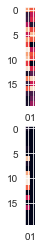

<Figure size 432x288 with 0 Axes>

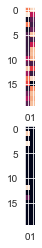

<Figure size 432x288 with 0 Axes>

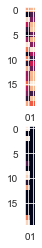

<Figure size 432x288 with 0 Axes>

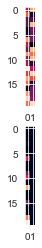

<Figure size 432x288 with 0 Axes>

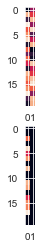

<Figure size 432x288 with 0 Axes>

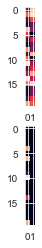

<Figure size 432x288 with 0 Axes>

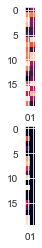

<Figure size 432x288 with 0 Axes>

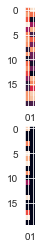

<Figure size 432x288 with 0 Axes>

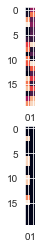

<Figure size 432x288 with 0 Axes>

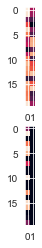

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


losses = train.train_model(
    model, data, labels, train_loader, test_loader, optimizer, config
)

In [10]:
angles = torch.linspace(0,2*torch.pi,1000)

norms = get_curv_profile(angles,model,embedding_dim)

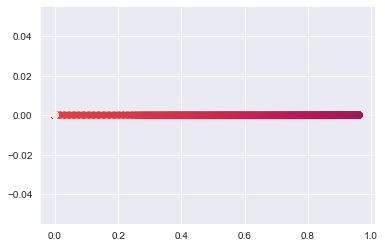

In [14]:
plot_model(angles, model)

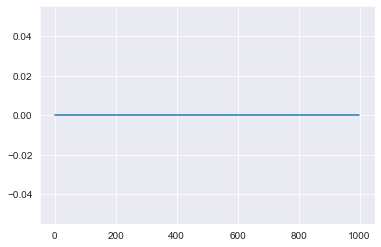

In [15]:
plt.plot(norms)